In [1]:
import numpy as np
import matplotlib.pyplot as plt
from well import Well
from geometry_keeper import GeometryKeeper
from scipy.integrate import quad
from scipy.special import k0, iti0k0
% matplotlib inline

In [2]:
from multifrac import Multifrac

In [3]:
outer_bound = "infinite"
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
n_stehf = 10
xwd = 0.
ywd = 0.
N = 20

params = {"nseg": N, "kx": 1., "ky": 1., "kz": 1., "omega": 1, "lambda": 1, "Fcd":10, "ref_length":1.,
         "z_ref_length": 1}
real_well = Well(xwd, ywd, outer_bound, top_bound, bottom_bound, wtype, params, n_stehf)
well = real_well.lapl_well

dyd = 1.
xws = np.array([0., 0., 0., 0., 0.])
yws = np.array([2*dyd, dyd, 0., -dyd, -2*dyd])
nwells = 5
mf = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf)
mf2 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf, "fixed_quad", 5)
mf_lapl = mf.lapl_well 
######


s = 1120

orig_shape = (nwells*params["nseg"]*2, nwells*params["nseg"]*2)
source_m  = mf_lapl.get_source_matrix(s)
right_matrix = well.get_green_matrix(s)
geo = mf_lapl.geo
green_matrix = np.zeros(geo.shape[0])
dyd_0_inds = np.argwhere(geo[:, 2] == 0.).flatten()
items_dyd_0 = geo[dyd_0_inds]
lims1 = items_dyd_0[:,0]
lims2 = items_dyd_0[:,1]
n_lims1 = len(lims1)
lims = np.append(lims1, lims2)
mask_1 = items_dyd_0[:,-2]
mask_2 = items_dyd_0[:,-1]
ulims, inds = np.unique(lims, return_inverse = True)
uvals = well.source.integrate_source_functions(s,
        np.zeros_like(ulims, dtype=np.float),
        ulims,
        np.zeros_like(ulims, dtype=np.float))
vals = uvals[inds]
vals1 = vals[:n_lims1]
vals2 = vals[n_lims1:]
vals = vals1*mask_1 + vals2*mask_2
green_matrix[dyd_0_inds] = vals
dyd_nnz_inds = np.argwhere(geo[:, 2] > 0.).flatten()
items_dyd_nnz = geo[dyd_nnz_inds][:,:3]
lims = items_dyd_nnz[:,:2]
upper_lims = np.max(lims, axis=1).reshape(-1, 1)
upper_lims_dyds = np.hstack([upper_lims, items_dyd_nnz[:,-1].reshape(-1, 1)])
ulims_dyd_nnz, inds_dyd_nnz = np.unique(upper_lims_dyds, axis=0, return_inverse=True)
uvals_dyd_nnz = well.source.integrate_source_functions(s,
        ulims_dyd_nnz[:, 0] - 1./params["nseg"],
        ulims_dyd_nnz[:, 0],
        ulims_dyd_nnz[:, 1])
vals_dyd_nnz = uvals_dyd_nnz[inds_dyd_nnz]
green_matrix[dyd_nnz_inds] = vals_dyd_nnz
green_matrix = green_matrix.reshape(orig_shape)
# green_matrix[:2*N, 2*N:] = 0.
# green_matrix[2*N:4*N, :2*N] = 0.
# green_matrix[2*N:4*N, 4*N:] = 0.
# green_matrix[4*N:,:4*N] = 0.
print(np.allclose(green_matrix[:2*params["nseg"],:2*params["nseg"]], right_matrix))
print(np.allclose(green_matrix[2*params["nseg"]:4*params["nseg"],2*params["nseg"]:4*params["nseg"]], right_matrix))
print(np.allclose(green_matrix[4*params["nseg"]:6*params["nseg"],4*params["nseg"]:6*params["nseg"]], right_matrix))
source_matrix = mf_lapl.get_source_matrix(s)
right_part = mf_lapl.get_right_part(s)
right_part[-1] = right_part[-1]
true_right_part = well.get_right_part(s)
true_source_matrix = well.get_source_matrix(s)
combined_matrix = np.zeros((1+nwells*params["nseg"]*2, 1+nwells*params["nseg"]*2), dtype = np.float)
combined_matrix[:-1,0] = 1.
combined_matrix[-1, 1:] = 1.
combined_matrix[:-1, 1:] = source_matrix - green_matrix
true_e_green_matrix = well.ext_green_matrix(right_matrix)
true_dummy_matrix = well.get_dummy_matrix()
true_combined_matrix = true_dummy_matrix - true_e_green_matrix + true_source_matrix
print("######")
solution = np.linalg.solve(combined_matrix, right_part)
true_solution = np.linalg.solve(true_combined_matrix, true_right_part)
print(solution[0])
print(true_solution[0])
print(true_solution[0]/solution[0])

True
True
True
######
2.19127949561e-05
0.000109563974781
5.0


In [4]:
t = .1
print(real_well.get_pw(t))
print(mf.get_pw(t))
print(real_well.get_pw(t)/mf.get_pw(t))

0.608048915865
0.123320012417
4.93065889266


In [5]:
ts = np.logspace(-3, 0, 30)

In [6]:
singles = []

for t in ts:
    singles.append(real_well.get_pw(t))


In [7]:
from time import time
multi = []
t1 = time()
for t in ts:
    multi.append(mf.get_pw(t))
print("done in {} s".format(time()-t1))

done in 28.24361538887024 s


In [8]:
import matplotlib.pyplot as plt
% matplotlib inline

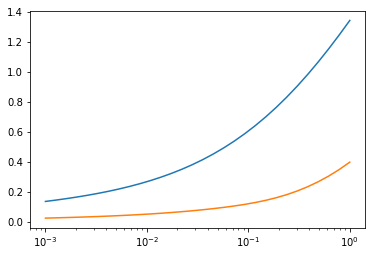

In [9]:
plt.xscale("log")
plt.plot(ts, singles)
plt.plot(ts, multi)

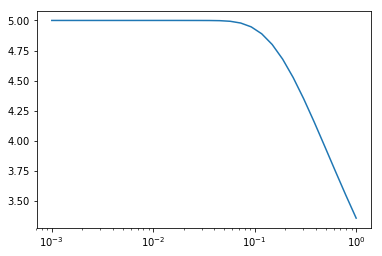

In [10]:
plt.xscale("log")
singles = np.array(singles)
multi = np.array(multi)
plt.plot(ts, singles/multi)

### Here I found that multifrac is Ok

In [11]:
mf2 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf, "fixed_quad", 5)

In [12]:
from time import time
multi2 = []
t1 = time()
for t in ts:
    multi2.append(mf2.get_pw(t))
print("done in {} s".format(time()-t1))

done in 22.54128909111023 s


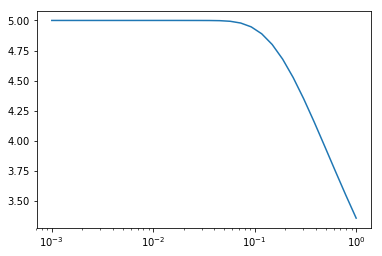

In [13]:
plt.xscale("log")
multi2 = np.array(multi2)
plt.plot(ts, singles/multi2)

In [14]:
dxd = 1.
xws = np.array([-2*dxd,  0.,  2*dxd])
yws = np.array([0., 0., 0.])
nwells = 3
mf3 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf)

In [15]:
multi3 = []
t1 = time()
for t in ts:
    multi3.append(mf3.get_pw(t))
print("done in {} s".format(time()-t1))

done in 1.57008957862854 s


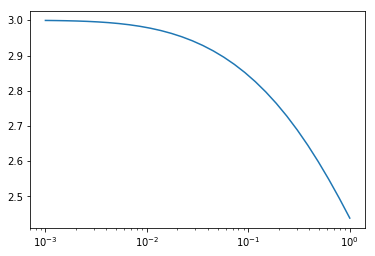

In [16]:
multi3 = np.array(multi3)
plt.xscale("log")
plt.plot(ts, singles/multi3)

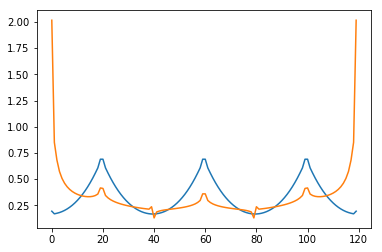

In [17]:
plt.plot(mf3.get_source_distribution(1e-3))
plt.plot(mf3.get_source_distribution(10))

In [3]:
outer_bound = "infinite"
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
n_stehf = 10
xwd = 0.
ywd = 0.
N = 10

params = {"nseg": N, "kx": 1., "ky": 1., "kz": 1., "omega": 1, "lambda": 1, "Fcd":10, "ref_length":1.,
         "z_ref_length": 1}
dyd = 1.
xws = np.array([0., 0., 0.])
yws = np.array([dyd, 0., -dyd])
nwells = 3
mf = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf)
mf_lapl = mf.lapl_well 

In [4]:
s = 7
old_green = mf_lapl.get_green_matrix(s)

In [21]:
from new_struct.well import Well as NewWell
outer_bound = "inf"
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
nseg = 10
nwells = 3
xwds = [0, 0, 0]
ywds = [-1, 0, 1]
x_lengths = 1
xed = None
yed = None
zwds = None
hd = None
mf_well_new = NewWell(outer_bound, top_bound, bottom_bound,
                    wtype, nseg, nwells, xwds, ywds, attrs = {"Fcd": 10})
mf_lapl_new = mf_well_new.lapl_well

In [6]:
mf_lapl_new.recalc(s)
new_green = mf_lapl_new.green_matrix[:-1,1:]

In [7]:
np.allclose(old_green, new_green)

True

In [8]:
old_green

array([[  1.57188789e-01,   7.67651680e-02,   4.44560318e-02, ...,
          2.25577507e-05,   1.87272867e-05,   1.54616792e-05],
       [  7.67651680e-02,   1.57188789e-01,   7.67651680e-02, ...,
          2.70096395e-05,   2.25577507e-05,   1.87272867e-05],
       [  4.44560318e-02,   7.67651680e-02,   1.57188789e-01, ...,
          3.21313292e-05,   2.70096395e-05,   2.25577507e-05],
       ..., 
       [  2.25577507e-05,   2.70096395e-05,   3.21313292e-05, ...,
          1.57188789e-01,   7.67651680e-02,   4.44560318e-02],
       [  1.87272867e-05,   2.25577507e-05,   2.70096395e-05, ...,
          7.67651680e-02,   1.57188789e-01,   7.67651680e-02],
       [  1.54616792e-05,   1.87272867e-05,   2.25577507e-05, ...,
          4.44560318e-02,   7.67651680e-02,   1.57188789e-01]])

In [9]:
new_green

array([[  1.57188789e-01,   7.67651680e-02,   4.44560318e-02, ...,
          2.25577507e-05,   1.87272867e-05,   1.54616792e-05],
       [  7.67651680e-02,   1.57188789e-01,   7.67651680e-02, ...,
          2.70096395e-05,   2.25577507e-05,   1.87272867e-05],
       [  4.44560318e-02,   7.67651680e-02,   1.57188789e-01, ...,
          3.21313292e-05,   2.70096395e-05,   2.25577507e-05],
       ..., 
       [  2.25577507e-05,   2.70096395e-05,   3.21313292e-05, ...,
          1.57188789e-01,   7.67651680e-02,   4.44560318e-02],
       [  1.87272867e-05,   2.25577507e-05,   2.70096395e-05, ...,
          7.67651680e-02,   1.57188789e-01,   7.67651680e-02],
       [  1.54616792e-05,   1.87272867e-05,   2.25577507e-05, ...,
          4.44560318e-02,   7.67651680e-02,   1.57188789e-01]])

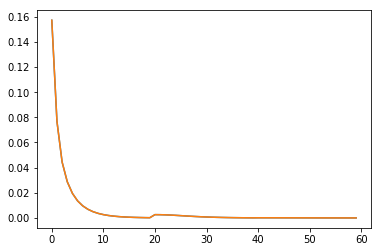

In [10]:
plt.plot(old_green[0,:])
plt.plot(new_green[0,:])

In [19]:
ts = np.logspace(-3,1,41)

In [22]:
from time import time

In [25]:
p_old = []
t1 =time()
for t in ts:
    p_old.append(mf.get_pw(t))
print(time()-t1)

4.890279769897461


In [27]:
p_new = []
t1 = time()
for t in ts:
    p_new.append(mf_well_new.pw(t))
print(time()-t1)

3.213183641433716


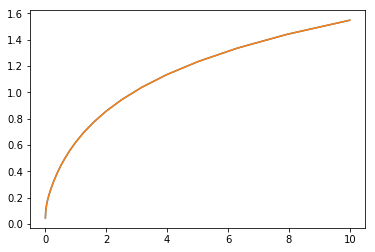

In [28]:
plt.plot(ts, p_old)
plt.plot(ts, p_new)

In [18]:
dxd = 3.
xws = np.array([-dxd, 0., dxd])
yws = np.array([0, 0., 0])
nwells = 3
mf_2 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf)

In [22]:
xwds = [-dxd, 0, dxd]
ywds = [0., 0., 0.]
x_lengths = 1
xed = None
yed = None
zwds = None
hd = None
mf_new_2 = NewWell(outer_bound, top_bound, bottom_bound,
                    wtype, nseg, nwells, xwds, ywds, attrs = {"Fcd": 10})

In [19]:
p_old_2 = []
t1 =time()
for t in ts:
    p_old_2.append(mf_2.get_pw(t))
print(time()-t1)

1.5800902843475342


In [23]:
p_new_2 = []
t1 =time()
for t in ts:
    p_new_2.append(mf_new_2.pw(t))
print(time()-t1)

0.1520087718963623


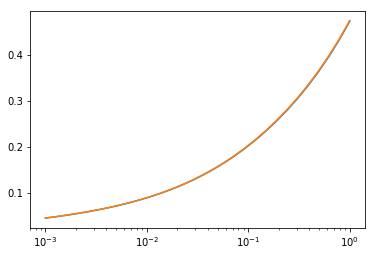

In [24]:
plt.xscale("log")
plt.plot(ts, p_old_2)
plt.plot(ts, p_new_2)

In [25]:
p_old_2

[0.046297795792128227,
 0.049302481260824038,
 0.052557354674874546,
 0.056095458950480293,
 0.059954402666647866,
 0.064176557238198484,
 0.068809213825943516,
 0.073904709681102077,
 0.079520520040915699,
 0.085719308911677672,
 0.09256892870757838,
 0.1001423396392056,
 0.10851740885942718,
 0.11777656578925644,
 0.12800624942650529,
 0.13929606091488722,
 0.1517375430854031,
 0.16542284729590051,
 0.18044375207824714,
 0.19689217895040656,
 0.21486325641154735,
 0.23446159721254389,
 0.25581047469967189,
 0.27906239933906818,
 0.30440857732492077,
 0.33208416387662965,
 0.36236718458792438,
 0.39556992273969627,
 0.43202439587457775,
 0.47206525056265036]

## Here I checked new class works OK

In [26]:
np.linalg.norm?